# Using EcoFOCIpy to apply Data Filters to 1D data

- filter examples:
    - 35hr Lanzcos Filter **good for data with tides like ADCP**
    - IQR (inter-quartile range) filter
    - STD (standard deviation) filter
    - 7pt rolling mean-value exceeds 5std of timeseries demeaned data **good for spiky data like chlor, sal in interface** and should be applied when there is a seasonal baseline shift (duration of rolling mean?) *TODO: make subroutine and output flag to variables*
    
    
- input:
    - timeseries data
- output:
    - timeseries data, flags
    
TODO:
- linearly fill (foward or back?) no more than x number of points (likely 1) -> interp_na(limit=1)
- output to xarray modified netcdf file

In [2]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import datetime

import EcoFOCIpy.math.cleaning as cleaning #<- instrument specific
import EcoFOCIpy.math.lanzcos as lanzcos #<- instrument specific

In [3]:
user_data_dir = '/Users/bell/ecoraid/2022/Moorings/22bs2c/working/'
filename = '22bs2c_eco_0045m.nc'
testfile = user_data_dir+filename

In [4]:
testfile = '09bs5b_eco_0018m.nc'

So lets load a timeseries and apply filters to the entire period

In [5]:
xdf = xa.load_dataset(testfile)
xdf

<xarray.Dataset>
Dimensions:             (time: 8666, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time                (time) datetime64[ns] 2009-09-29T23:00:00 ... 2010-09-26
  * latitude            (latitude) float64 59.92
  * longitude           (longitude) float64 -171.7
  * depth               (depth) float64 18.0
Data variables:
    chlor_fluorescence  (time, depth, latitude, longitude) float64 5.155 ... ...
Attributes: (12/15)
    Latitude_DegMMddW:                      59 54.998 N
    Longitude_DegMMddN:                     171 42.244 W
    MooringID:                              09BS-5B
    platform_deployment_date:               2009-09-29T22:02:00Z
    platform_deployment_cruise_name:        MF0904L2
    platform_recovery_date:                 2010-09-26T00:00:00Z
    ...                                     ...
    InstrumentSerialNumber:                 659
    InstrumentType:                         Eco-Fluorometer FLSB
    date_created:                           2024-02-21T11:16:24Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [6]:
var_choice = 'chlor_fluorescence'

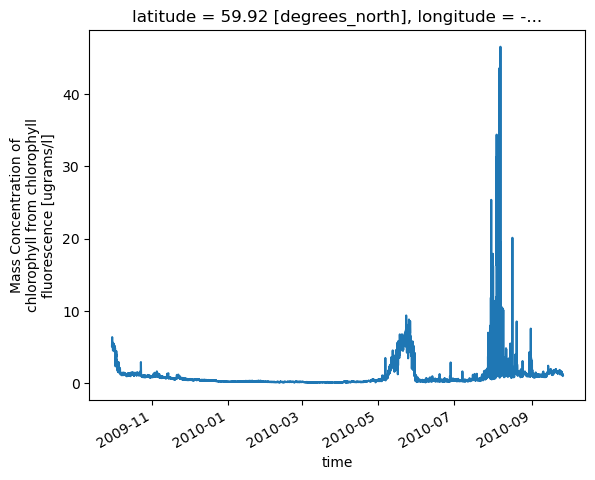

In [7]:
xdf[var_choice].plot()

In [8]:
df = xdf[var_choice][:,0,0,0].to_dataframe().drop(labels=['depth','latitude','longitude'],axis=1)
dft = df.dropna()
#
## missing data fill limited by number of hours to linearly interpolate
temp = dft[var_choice].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temp)
temp = dft[var_choice].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

#filter data with lanzcos filter
lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[var_choice].mean()

In [9]:
IQRcleaned = cleaning.outlier_bounds_iqr(xdf[var_choice])
STDcleaned = cleaning.outlier_bounds_std(xdf[var_choice])

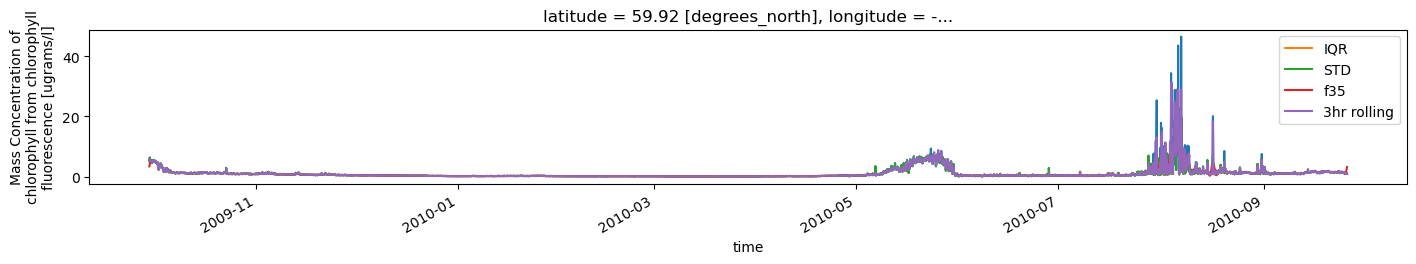

In [10]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()


But perhaps a form of rolling std/iqr filter is more appropriate as it wont tend to mask relevant peaks by being a median filter

In [11]:
xdf

<xarray.Dataset>
Dimensions:             (time: 8666, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time                (time) datetime64[ns] 2009-09-29T23:00:00 ... 2010-09-26
  * latitude            (latitude) float64 59.92
  * longitude           (longitude) float64 -171.7
  * depth               (depth) float64 18.0
Data variables:
    chlor_fluorescence  (time, depth, latitude, longitude) float64 5.155 ... ...
Attributes: (12/15)
    Latitude_DegMMddW:                      59 54.998 N
    Longitude_DegMMddN:                     171 42.244 W
    MooringID:                              09BS-5B
    platform_deployment_date:               2009-09-29T22:02:00Z
    platform_deployment_cruise_name:        MF0904L2
    platform_recovery_date:                 2010-09-26T00:00:00Z
    ...                                     ...
    InstrumentSerialNumber:                 659
    InstrumentType:                         Eco-Fluorometer FLSB
    date_created:                           2024-02-21T11:16:24Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

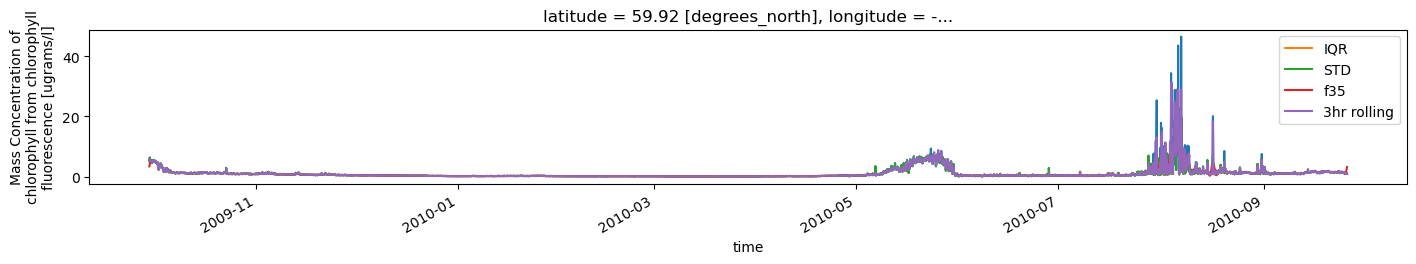

In [12]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()

*Finally* try to refill as many points back to the start and finish of the 

In [13]:
N = 3
clean = cleaning.rolling_outlier_std(xdf,var_choice,timebase=N*2+1,stddev=5,interp_fill_timebase='1H')
clean[var_choice][:N+1] = xdf[var_choice][:N+1]
clean[var_choice][-N-1:] = xdf[var_choice][-N-1:]

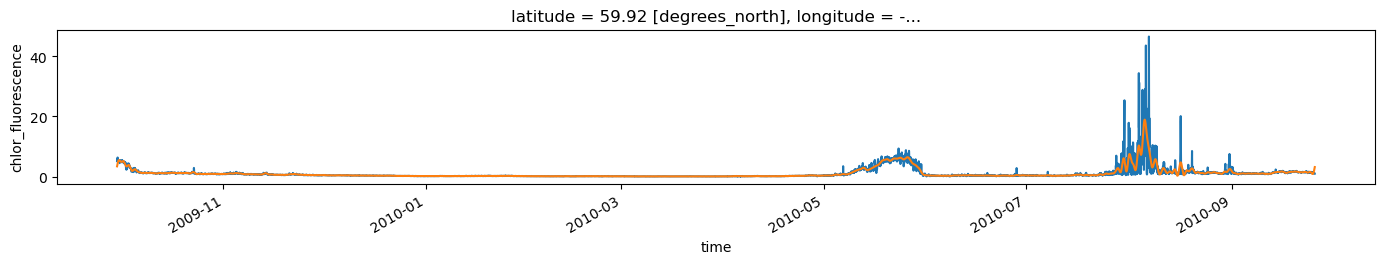

In [30]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)

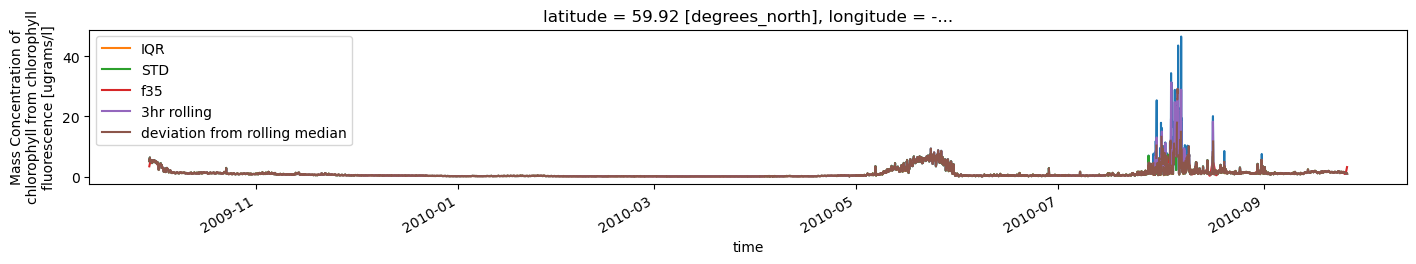

In [14]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)
clean[var_choice].plot(label='deviation from rolling median', ax=ax)

ax.legend()

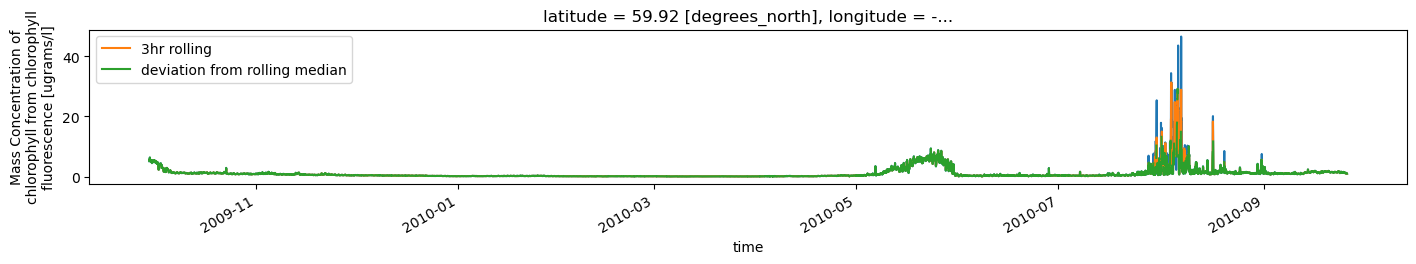

In [15]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
# ((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
# ((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
# ((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)
clean[var_choice].plot(label='deviation from rolling median', ax=ax)

ax.legend()

In [16]:
clean

<xarray.Dataset>
Dimensions:                (time: 8666, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time                   (time) datetime64[ns] 2009-09-29T23:00:00 ... 2010...
  * latitude               (latitude) float64 59.92
  * longitude              (longitude) float64 -171.7
  * depth                  (depth) float64 18.0
Data variables:
    chlor_fluorescence     (time, depth, latitude, longitude) float64 5.155 ....
    chlor_fluorescence_QC  (time, depth, latitude, longitude) float64 1.0 ......
Attributes: (12/15)
    Latitude_DegMMddW:                      59 54.998 N
    Longitude_DegMMddN:                     171 42.244 W
    MooringID:                              09BS-5B
    platform_deployment_date:               2009-09-29T22:02:00Z
    platform_deployment_cruise_name:        MF0904L2
    platform_recovery_date:                 2010-09-26T00:00:00Z
    ...                                     ...
    InstrumentSerialNumber:                 659
    InstrumentType:                         Eco-Fluorometer FLSB
    date_created:                           2024-02-21T11:16:24Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [17]:
clean.to_dataframe().to_csv(testfile.replace('.nc','.despiked.csv'))

## Apply to datastream

In [18]:
clean.attrs.update({'QC_indicator': 'ProbablyGood'})
clean.attrs.update({'history':(clean.history + "\nQCd: "+ str(datetime.datetime.today()) + '3hr rolling std filter applied to chlor - >5std removed')})

In [19]:
clean.attrs.update({'date_modified':str(datetime.datetime.today())})

In [20]:
clean.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})

/var/folders/g1/6qjvrwsx0vb6ltz_4gv0tmxr0000jm/T/ipykernel_93870/2426986850.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  clean.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})


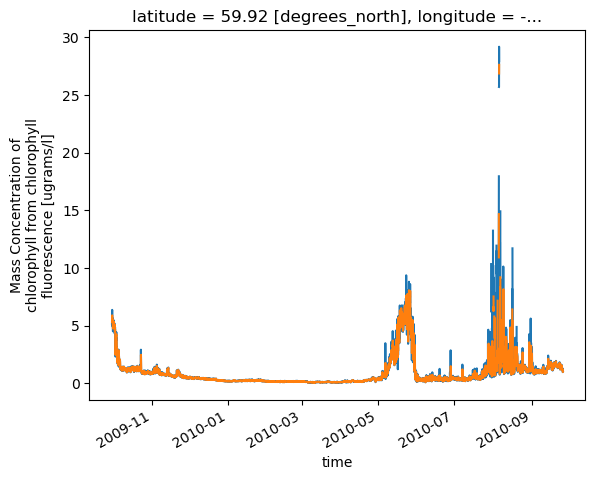

In [29]:
clean.chlor_fluorescence.plot()
clean.chlor_fluorescence.rolling(time=3).mean().plot()